In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

import gym

In [3]:
#Import Custom Classes

from Source.NN_model_2 import QNetwork
from Source.dqn_agent_2 import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.Env_Manager import EnvManager
from Source.Misc import plot, get_moving_average



In [4]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 60             #minibatch size
GAMMA = 0.999                #discount factor
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
eps_start = 1
eps_end = 0.01
eps_decay = 0.9983 #125e-6
train_episodes = 2500
test_episodes = 1
seed = 0                    #random seed number
episode_step_limit = 50

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Choose the environment
em = EnvManager(device, 'uav-v5', seed)


available_actions = em.num_actions_available()
random.seed(seed)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

#Initialize the agent
agent = Agent(strategy, available_actions, seed, device)

#Instantiate MemoryBuffer
memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)

policy_net = QNetwork(available_actions, seed).to(device)
target_net = QNetwork(available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=32, bias=True)
)


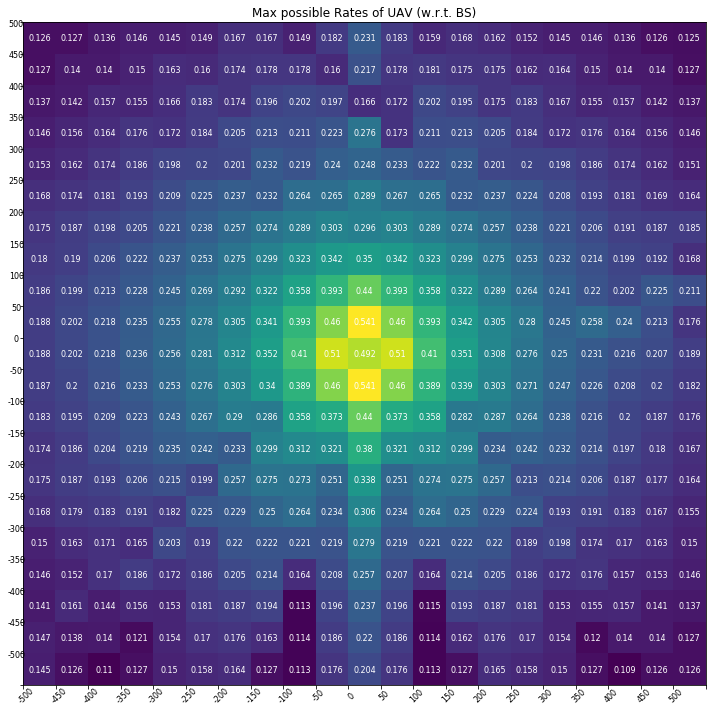

In [7]:
exh_rates_fname = 'env_exh_rates_mpath.txt'
ue_xloc = em.env.ue_xloc  #20 locs
ue_yloc = em.env.ue_yloc[::-1]     #20 locs

if os.path.exists(exh_rates_fname):
    rate_arr = np.loadtxt(exh_rates_fname, dtype=float)
else:
    # File is empty
    rate_tr = 0.0
    t_step = 0

    rate_arr = np.zeros([(max(ue_yloc)-min(ue_yloc))//50 +1, (max(ue_xloc)-min(ue_xloc))//50 + 1]) #(-500,50) -----> (500,500)
    for y_ndx in range(len(ue_yloc)):
        for x_ndx in range(len(ue_xloc)):
            state = np.array([ue_xloc[x_ndx], ue_yloc[y_ndx]])/ em.env.high_obs
            exh_bdir,exh_rate = em.env.get_Exh_Rate(state)
            rate_arr[y_ndx,x_ndx] = np.around(exh_rate, decimals=3)
    np.savetxt(exh_rates_fname, rate_arr, fmt='%f')

row_labels = [str(x) for x in ue_yloc]
col_labels = [str(x) for x in ue_xloc]

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(rate_arr, aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(rate_arr.shape[1]+1)-.5)
ax.set_yticks(np.arange(rate_arr.shape[0]+1)-.5)
# ... and label them with the respective list entries
ax.set_xticklabels(col_labels, fontsize=8)
ax.set_yticklabels(row_labels, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="center",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(rate_arr.shape[0]):
    for j in range(rate_arr.shape[1]):
        text = ax.text(j, i, rate_arr[i, j],
                       ha="center", va="center", color="w", fontsize=8)

ax.set_title("Max possible Rates of UAV (w.r.t. BS)")
fig.tight_layout()
plt.show()    


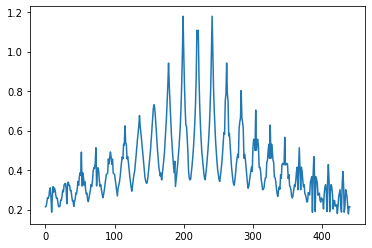

In [8]:
rate_arr = rate_arr.flatten()

plt.plot(rate_arr)
plt.show()

In [9]:
rate_thr_indices = [24, 175, 80, 157, 179, 284]

for i in rate_thr_indices:
    print(rate_arr[i])

0.268
0.666
0.326
0.731
0.832
0.664


[0.39269908 0.78539816 1.17809725 1.57079633 1.96349541 2.35619449
 2.74889357 3.14159265 3.53429174]
[0.3926990816987242, 0.7853981633974483, 1.1780972450961724, 1.5707963267948966, 1.9634954084936207, 2.356194490192345, 2.748893571891069, 3.141592653589793, -2.7488935718910694]


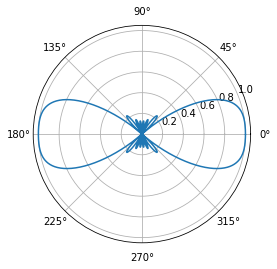

In [10]:
ang=np.arange(np.pi/8, 10*np.pi/8, np.pi/8)
print(ang)
tan_ang=[]
for a in ang:
    tan_ang.append(np.arctan2(np.sin(a), np.cos(a)))
    
print(tan_ang)

from Source.MIMO import plotbeam

theta, gr = plotbeam(np.pi, 8)
ax = plt.subplot(111, projection='polar')
ax.plot(theta, gr)
plt.show()

In [11]:
selected_rate_ndx = 175
print(rate_arr[selected_rate_ndx])
rate_thr = rate_arr[selected_rate_ndx]

0.666


Testing Environment with untrained Agent

torch.Size([1, 2])
action:  26
action:  31
action:  19
action:  22
action:  13


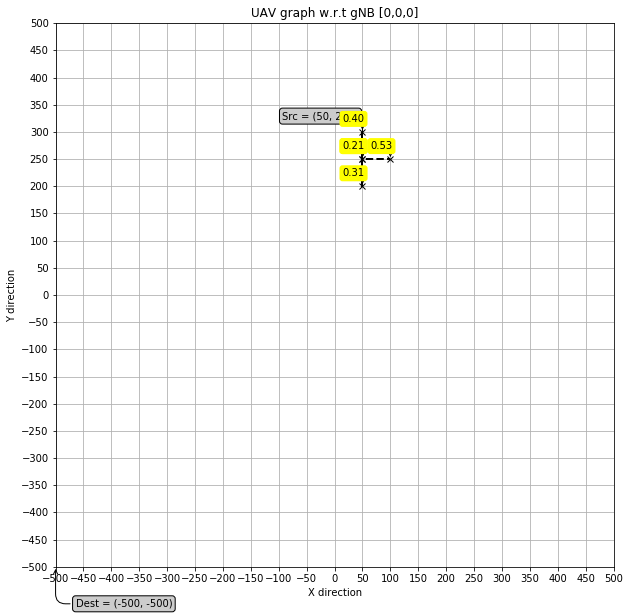

UAV Source: (array([50]), array([250])), UAV dest: (-500, -500)


In [12]:
state_indices = em.env.obs_space.sample()
state = em.reset(rate_thr, 'rate_thr_path', state_indices)
#state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
print(state.shape)
for j in range(5):
    action = agent.act(state, policy_net)
    print("action: ", action.item())
    #print("Action: {}, Qval: {}".format(action, qval))
    #env.render()
    #print("[NB] action: {}".format(action))
    state, reward, done, _ = em.step(action)
    #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    if done:
        break 
        
em.env.render()      
em.close()
print("UAV Source: {0}, UAV dest: {1}".format((em.env.ue_xsrc, em.env.ue_ysrc), (em.env.ue_xdest[0], em.env.ue_ydest[0]) ))

Training the DQN Agent

In [13]:
#Training Loop
episode_durations = []
episode_rewards = []
policy_net.train()

#import progressbar as pb
#widget = ['training loop: ', pb.Percentage(), ' ', 
#          pb.Bar(), ' ', pb.ETA() ]
#timer = pb.ProgressBar(widgets=widget, maxval=train_episodes).start()
outer = tqdm.tqdm_notebook(total=train_episodes, desc='training loop: ', position=0)

for episode in range(train_episodes):
    state_indices = em.env.obs_space.sample()
    state = em.reset(rate_thr, 'rate_thr_path', state_indices)
    
    #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    agent.current_step +=1
    for timestep in count():
        action = agent.act(state, policy_net)
        next_state, reward, done, _ = em.step(action)
        ep_rwd += reward.item()
        memory.add(state, action, reward, next_state, done)
        
        state = next_state
        #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            states, actions, rewards, next_states, dones = experiences
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(states).gather(1,index=actions.unsqueeze(-1))
            next_q_values = target_net(next_states).detach().max(1)[0]
            target_q_values = (next_q_values*GAMMA) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            #print("loss: ", loss.item())
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (timestep==episode_step_limit) or done:
            episode_durations.append(timestep)
            episode_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, episode_rewards)
            print('\rEpisode {}\t timestep: {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}'.format(episode+1, timestep, ep_rwd, agent.strategy.get_exploration_rate(agent.current_step), moving_avg_rwd[-1]), end="\r")
            #plot(episode_rewards, 100)
            break
            
        
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if (np.mean(episode_rewards[-100:]) >= 20000):
        print("Goal is reached in {} episodes!\n".format(episode))
        break
        
    
    
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')    
#timer.finish()
plot(episode_rewards, 100)
#em.close()


KeyboardInterrupt: 

In [ ]:
#Plot Training curve
plt.figure()
plt.clf()
plt.xlabel('Episode #')
plt.ylabel('Reward')

#for i in range(0, len(episode_rewards), 100):
plt.plot(get_moving_average(200, episode_rewards))
    
#plt.grid()
#plt.legend()
#plt.savefig('dronerl_training_logfn_230120.pdf')
plt.show()

In [ ]:
#Setting up and training DQN for shortest path planning
#Choose the environment
sp_em = EnvManager(device, 'uav-v4', seed)

sp_actions = sp_em.num_actions_available()
random.seed(seed)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

#Initialize the agent
sp_agent = Agent(strategy, sp_actions, seed, device)

#Instantiate MemoryBuffer
sp_memory = ReplayBuffer(sp_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)

sp_policy_net = QNetwork(sp_actions, seed).to(device)
sp_target_net = QNetwork(sp_actions, seed).to(device)
print(sp_policy_net)

#Initialize target_net weights to policy_net weights
sp_target_net.load_state_dict(sp_policy_net.state_dict())
sp_target_net.eval() #Set the target_net in eval mode

#Select the optimizer
sp_optimizer = optim.Adam(params=sp_policy_net.parameters(), lr=LR)


## Training shortest path DQN Agent

In [ ]:
#Training Loop
sp_episode_durations = []
sp_episode_rewards = []
sp_policy_net.train()

#import progressbar as pb
#widget = ['training loop: ', pb.Percentage(), ' ', 
#          pb.Bar(), ' ', pb.ETA() ]
#timer = pb.ProgressBar(widgets=widget, maxval=train_episodes).start()
outer = tqdm.tqdm_notebook(total=train_episodes, desc='training loop: ', position=0)

for episode in range(train_episodes):
    state_indices = sp_em.env.obs_space.sample()
    state = sp_em.reset(state_indices=state_indices)
    
    #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    sp_agent.current_step +=1
    for timestep in count():
        action = sp_agent.act(state, sp_policy_net)
        next_state, reward, done, _ = sp_em.step(action)
        ep_rwd += reward.item()
        sp_memory.add(state, action, reward, next_state, done)
        
        state = next_state
        #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        if sp_memory.can_provide_sample():
            experiences = sp_memory.sample()
            states, actions, rewards, next_states, dones = experiences
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = sp_policy_net(states).gather(1,index=actions.unsqueeze(-1))
            next_q_values = sp_target_net(next_states).detach().max(1)[0]
            target_q_values = (next_q_values*GAMMA) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            #print("loss: ", loss.item())
            ep_loss += loss.item()
            
            sp_optimizer.zero_grad()
            loss.backward()
            sp_optimizer.step()
        
        if (timestep==episode_step_limit) or done:
            sp_episode_durations.append(timestep)
            sp_episode_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, sp_episode_rewards)
            print('\rEpisode {}\t timestep: {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}'.format(episode+1, timestep, ep_rwd, sp_agent.strategy.get_exploration_rate(sp_agent.current_step), moving_avg_rwd[-1]), end="\r")
            #plot(episode_rewards, 100)
            break
            
        
    if episode % UPDATE_EVERY == 0:
        sp_target_net.load_state_dict(sp_policy_net.state_dict())
    
    if (np.mean(sp_episode_rewards[-100:]) >= 20000):
        print("Goal is reached in {} episodes!\n".format(episode))
        break
    
    # update tqdm bar
    outer.update(1)
    
torch.save(sp_policy_net.state_dict(), 'sp_checkpoint.pth')    
#timer.finish()
plot(sp_episode_rewards, 100)

## Testing the DQN agent

In [ ]:
#Load the weights from file
policy_net.load_state_dict(torch.load('checkpoint.pth'))
#rate_thr = rate_arr[120]
dest_loc = np.array([em.env.ue_xdest[0], em.env.ue_ydest[0]])

exh_rates = []
exh_bdirs= []
learnt_bdirs=[]
model_ue_dist = []
learnt_val_fns = []
true_val_fns = []
test_scores = []
policy_net.eval()
for i_episode in range(1):
    
    state_indices = (19,19) #[450,450] location em.env.obs_space.sample()
    state_tensor = em.reset(rate_thr, 'rate_thr_path', state_indices)
    learnt_val_fn = 0.0
    true_val_fn = 0.0
    perf_score = 0
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        next_state_tensor, reward, done, _ = em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        print("Current State: ", state)
        print("Next State: ", next_state)
        
        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        
        temp = np.array([next_state[0], next_state[1]]) - dest_loc
        dist = np.sqrt(temp[0]**2 + temp[1]**2)
        
        #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        
        #rate measurements
        learnt_rate = em.env.get_Rate()
        _,los_rate = em.env.get_Los_Rate(next_state)
        exh_bdir,exh_rate = em.env.get_Exh_Rate(next_state)
        
        learnt_val_fn += ((GAMMA**(t_step)) * (learnt_rate))
        true_val_fn += ((GAMMA**(t_step)) * (exh_rate))
        
        rbd_ndx, ue_mv_ndx = em.env.decode_action(action)
        ue_vx, ue_vy = em.env.choose_vel(ue_mv_ndx)
        print("time step: ", t_step+1)
        print("action parameters: ue_vx: {}, ue_vy: {}".format(ue_vx, ue_vy))
        print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, em.env.BeamSet[rbd_ndx]))
        print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}\n\n".format(learnt_rate, exh_rate, los_rate, reward))
        
        exh_rates.append(exh_rate)
        exh_bdirs.append(exh_bdirs)
        learnt_bdirs.append(em.env.BeamSet[rbd_ndx])
        model_ue_dist.append(dist)
        if (t_step== episode_step_limit) or done:
            em.env.render()
            break

## Testing the shortest path DQN agent

In [ ]:
#Load the weights from file
sp_policy_net.load_state_dict(torch.load('sp_checkpoint.pth'))
#rate_thr = rate_arr[120]

sp_exh_rates = []
sp_exh_bdir = []
learnt_val_fns = []
true_val_fns = []
sp_test_scores = []
sp_policy_net.eval()
for i_episode in range(1):
    
    state_indices = (19,19) #[450,450] location em.env.obs_space.sample()
    state_tensor = sp_em.reset(rate_thr, 'rate_thr_path', state_indices)
    learnt_val_fn = 0.0
    true_val_fn = 0.0
    perf_score = 0
    for t_step in count():
        action = sp_policy_net(state_tensor).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        next_state_tensor, reward, done, _ = sp_em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * sp_em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * sp_em.env.high_obs)
        print("Current State: ", state)
        print("Next State: ", next_state)
        
        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        next_state = next_state / sp_em.env.high_obs
        state = state / sp_em.env.high_obs
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        
        #rate measurements
        learnt_rate = sp_em.env.get_Rate()
        _,los_rate = sp_em.env.get_Los_Rate(next_state)
        exh_bdir,exh_rate = sp_em.env.get_Exh_Rate(next_state)
        
        
        learnt_val_fn += ((GAMMA**(t_step)) * (learnt_rate))
        true_val_fn += ((GAMMA**(t_step)) * (exh_rate))
        
        ue_mv_ndx = sp_em.env.decode_action(action)
        ue_vx, ue_vy = sp_em.env.choose_vel(ue_mv_ndx)
        print("time step: ", t_step+1)
        print("action parameters: ue_vx: {}, ue_vy: {}".format(ue_vx, ue_vy))
        print("exh dir: {0}".format(exh_bdir))
        print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}\n\n".format(learnt_rate, exh_rate, los_rate, reward))
        
        sp_exh_rates.append(exh_rate)
        sp_exh_bdir.append(exh_bdir)
        if (t_step== episode_step_limit) or done:
            sp_em.env.render()
            break

## Compare joint path planning and beam learning problem with Shortest path planning with Optimal beam tracking

In [ ]:
#optimal beam tracking is performed by exhaustive search method
from matplotlib.path import Path
import matplotlib.patches as patches

#src, dest and gNB locations
src_xndx, src_yndx = (19,19) #[450,450]
src_loc = np.array([em.env.ue_xloc[src_xndx],em.env.ue_yloc[src_yndx]])
dest_loc = np.array([em.env.ue_xdest[0], em.env.ue_ydest[0]])
gNB_loc = np.array([em.env.gNB[0][0], em.env.gNB[0][1]]) #2D location

#rate_thr_path
rate_thr_path = em.env.ue_path
rate_thr_path_rates = em.env.ue_path_rates
rate_thr_verts = [(int(x[0]), int(x[1])) for x in rate_thr_path]
rate_thr_codes = [Path.LINETO for x in range(len(rate_thr_verts))]
rate_thr_codes[0] = Path.MOVETO
rate_thr_codes[-1] = Path.STOP
rate_thr_path  = Path(rate_thr_verts, rate_thr_codes)

rate_ndx = selected_rate_ndx
rate_thr = np.around(rate_arr[rate_ndx], decimals=1)

#short_path planning
short_path = sp_em.env.ue_path
short_path_rates = sp_exh_rates
short_verts = [(int(x[0]), int(x[1])) for x in short_path]
short_codes = [Path.LINETO for x in range(len(short_verts))]
short_codes[0] = Path.MOVETO
short_codes[-1] = Path.STOP
short_path  = Path(short_verts, short_codes)

print("rate thr Count: {}, short path count: {}".format(len(rate_thr_path), len(short_path)))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
rate_thr_patch = patches.PathPatch(rate_thr_path, facecolor='none', lw=2)
short_patch = patches.PathPatch(short_path, facecolor='none', lw=2)
ax.add_patch(rate_thr_patch)
ax.add_patch(short_patch)

rate_thr_xs, rate_thr_ys = zip(*rate_thr_verts)
ax.plot(rate_thr_xs, rate_thr_ys, 'x-', lw=2, color='red', label='proposed joint path')

short_xs, short_ys = zip(*short_verts)
ax.plot(short_xs, short_ys, '*--', lw=2, color='black', label='short path')

bbox = dict(boxstyle="round", facecolor='burlywood', edgecolor='none')
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

offset = 50
#Plot src and dest
ax.plot(src_loc[0], src_loc[1], marker='o',markersize=15, color='brown', label='Src = (%d, %d)' % (src_loc[0], src_loc[1]))
ax.plot(dest_loc[0], dest_loc[1], marker='X',markersize=15, color='brown', label='Dest = (%d, %d)' % (dest_loc[0], dest_loc[1]))

#Plot gNB
bbox = dict(boxstyle="round", facecolor='burlywood', edgecolor='none')
arrowprops1 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=135,rad=10")
ax.plot(gNB_loc[0], gNB_loc[1], marker='d', markersize=15, color='darkorange', label='gNB = (%d, %d)' % (gNB_loc[0], gNB_loc[1]))

#Plot scatterers
sc_points = em.env.sc_xyz
bbox = dict(boxstyle="round", facecolor='blue', edgecolor='none')
arrowprops1 = dict(
        arrowstyle="->",
        connectionstyle="angle,angleA=0,angleB=135,rad=10")
for i in range(len(sc_points)):
    ax.plot(em.env.sc_xyz[i][0], em.env.sc_xyz[i][1], marker='s', markersize=12, color='darkblue', label='rp%d = (%d, %d)' % (i+1, em.env.sc_xyz[i][0], em.env.sc_xyz[i][1]))

#Annotate rate values on short and proposed rate_thr path 
offset= 12
for i in range(0,len(short_path_rates)-1):
    xytext2 = (-2 * offset, offset)
    
    if (i== (len(short_path_rates)-2)):
        xytext1=(-1.5 * offset, -1*offset)
    elif((short_verts[i][0], short_verts[i][1]) == (rate_thr_verts[i][0], rate_thr_verts[i][1])):
        xytext1=(1 * offset, -1*offset)
    elif (i>0) and (short_verts[i][0] < short_verts[i-1][0]):
        xytext1=(-2 * offset, 1*offset)
    elif(short_verts[i][0] < rate_thr_verts[i][0]):
        xytext1=(-1 * offset, 1*offset)
        xytext2=(1 * offset, 1*offset)
    elif(short_verts[i][0] > rate_thr_verts[i][0]):
        xytext1=(1 * offset, -1*offset)
   
    else:
        xytext1=(-1 * offset, -1*offset)
        
    #if (np.around(short_path_rates[i], decimals=1) >= rate_thr):
    #    facecolor1 = 'lightgreen'
    #else:
    facecolor1 = 'lightgrey'
    
    
    if(i>0) and (rate_thr_verts[i][0] < rate_thr_verts[i-1][0]):
        xytext2=(-1.5 * offset, 1*offset)
           
    #if (np.around(rate_thr_path_rates[i], decimals=1) >= rate_thr):
    #    facecolor2 = 'lightgreen'
    #else:
    facecolor2 = 'lightcoral'

    bbox1 =dict(boxstyle="round", facecolor=facecolor1, edgecolor='none')
    ax.annotate('{0:.1f}'.format(np.around(short_path_rates[i], decimals=1)) ,
                (short_verts[i][0], short_verts[i][1]), xytext=xytext1, textcoords='offset points',
                bbox=bbox1, arrowprops=arrowprops,size=9)
    
    bbox2 =dict(boxstyle="round", facecolor=facecolor2, edgecolor='none')
    
    ax.annotate('{0:.1f}'.format(np.around(rate_thr_path_rates[i], decimals=1)) ,
                (rate_thr_verts[i][0], rate_thr_verts[i][1]), xytext=xytext2, textcoords='offset points',
                bbox=bbox2, arrowprops=arrowprops,size=9)

ax.grid(alpha=0.5)
ax.set_xticks(em.env.ue_xloc)
ax.set_yticks(em.env.ue_yloc)
ax.tick_params(direction='out', length=2, width=2)
#ax.set_title("UAV graph w.r.t gNB [0,0,0]")
ax.set_xlabel("X direction (m)", fontsize=15)
ax.set_ylabel("Y direction (m)", fontsize=15)
ax.legend(loc='center', bbox_to_anchor=(0.55, -0.10, .5, .5), fontsize='medium')
#plt.savefig('rate_thr_test_episode_logfn_230120.pdf')
plt.show()

In [ ]:
#beam learning in proposed approach vs exhaustive beam search along the same test path

plt.figure(figsize=(8,8))
plt.clf()
plt.xlabel('UAV Distance (m) w.r.t destination:({0},{1})'.format(dest_loc[0],dest_loc[1]))
plt.ylabel('Cumsum[Rate] (Gbps)')

colors = ['blue','red','green']


exh_rate_change = np.array(exh_rates[:-1])
model_ue_dist = np.array(model_ue_dist[:-1])
#for i in range(len(models)-1):
learnt_rate_change = np.array(em.env.ue_path_rates[:-1])    

print(model_ue_dist)
print(learnt_rate_change)
print(exh_rate_change)

plt.plot(np.around(model_ue_dist, decimals=1), np.around(np.cumsum(learnt_rate_change), decimals=1), label='learnt rate for proposed path from src:({0},{1})'.format(src_loc[0],src_loc[1]), color=colors[1])
plt.plot(np.around(model_ue_dist, decimals=1), np.around(np.cumsum(exh_rate_change), decimals=1), '--', color=colors[0], label='exh rate for proposed path src:({0},{1})'.format(src_loc[0],src_loc[1]))

#plt.plot(ue_path_rates[i])
plt.grid()
plt.legend()
#plt.savefig('cumrate_distance_plot_logfn_210120.pdf')
plt.show()

Compute the value function

#Load the weights from file
policy_net.load_state_dict(torch.load('checkpoint.pth'))
test_episodes = 20

rate_acc_los_scores = []
rate_acc_exh_scores = []
learn_perf_scores = []
trad_perf_scores=[]
learnt_val_fns = []
true_val_fns = []
test_scores = []
eps_times = []
policy_net.eval()

for i_episode in range(1, test_episodes+1):
    
    learnt_rates = 0.0
    los_rates = 0.0
    exh_rates = 0.0
    state_indices = em.env.obs_space.sample()
    state_tensor = em.reset(rate_thr, 'rate_thr_path', state_indices)
    learnt_val_fn = 0.0
    true_val_fn = 0.0
    learn_perf_score = 0
    trad_perf_score = 0
    
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        
        next_state_tensor, reward, done, _ = em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        #print("Current State: ", state)
        #print("Next State: ", next_state)

        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        #print("Learnt Action: ", test_net(state))
        
            
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        
        #rate measurements
        learnt_rate = em.env.get_Rate()
        _,los_rate = em.env.get_Los_Rate(next_state)
        exh_bdir,exh_rate = em.env.get_Exh_Rate(next_state)
        
        learnt_val_fn += ((GAMMA**(t_step)) * (learnt_rate))
        true_val_fn += ((GAMMA**(t_step)) * (exh_rate))
        
        #rbd_ndx, ue_vx_ndx, ue_vy_ndx = em.env.decode_action(action)
        #print("time step: ", t_step+1)
        #print("action parameters: ue_vx: {0}, ue_vy: {1}".format(em.env.ue_vx[ue_vx_ndx], em.env.ue_vx[ue_vx_ndx]))
        #print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, em.env.BeamSet[rbd_ndx]))
        #print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}\n\n".format(learnt_rate, exh_rate, los_rate, reward))
        if (learnt_rate >= np.around(em.env.rate_threshold, decimals=1)):
            learn_perf_score +=1
        if (exh_rate >= np.around(em.env.rate_threshold, decimals=1)):
            trad_perf_score +=1

        los_rates+=los_rate
        exh_rates+=exh_rate
        learnt_rates+=learnt_rate
        
        if (t_step== episode_step_limit) or done:
            rate_acc_los = learnt_rates/ los_rates
            rate_acc_exh = learnt_rates / exh_rates
            print("\rTest epsiode: {}\t rate_acc_los: {:.2f}\trate_acc_exh: {:.2f}, episode_len: {}, perf_score: {}".format(i_episode, rate_acc_los, rate_acc_exh, t_step, learn_perf_score))
            rate_acc_los_scores.append(rate_acc_los)
            rate_acc_exh_scores.append(rate_acc_exh)
            learn_perf_scores.append(learn_perf_score)
            trad_perf_scores.append(trad_perf_score)
            eps_times.append(t_step)
            
            learnt_val_fns.append(learnt_val_fn)
            true_val_fns.append(true_val_fn)
            break

Plot Rate Accuracies

print("Avg rate_los_acc: {}, Avg rate_exh_acc: {}".format(np.mean(rate_acc_los_scores), np.mean(rate_acc_exh_scores)))



# plot the histogram
w=0.3
fig = plt.figure(figsize=(10,10))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis-w, learnt_val_fns, w, color='b')
rects2= ax.bar(x_axis, true_val_fns, w, color='g')
#plt.legend(loc='upper right')
ax.legend( (rects1[0], rects2[0]), ('rl_val_fn', 'exh_val_fn'), loc='upper right' )
plt.ylabel('Value Function')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)
ax.set_yticks(np.arange(0.0,50,2))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        #ax.text(rect.get_x()+rect.get_width()/2., 1.03*h, '%.2f'%np.around(h, decimals=2),
        #        ha='center', va='bottom')

ax.axhline(np.mean(learnt_val_fns), color='b', linewidth=0.75, linestyle='--')
ax.axhline(np.mean(true_val_fns), color='g', linewidth=0.75, linestyle='--')
autolabel(rects1)
autolabel(rects2)
plt.show()

Plot Efficiency Scores

rl_efficiency_scores = [ x for x in learnt_val_fns]
exh_efficiency_scores = [x/em.env.N_rx for x in true_val_fns]

print("Avg Efficiceny_RL: {}, Avg Efficiency_Exh: {}".format(np.mean(rl_efficiency_scores), np.mean(exh_efficiency_scores)))



# plot the histogram
w=0.3
fig = plt.figure(figsize=(10,10))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis-w, rl_efficiency_scores, w, color='b')
rects2= ax.bar(x_axis, exh_efficiency_scores, w, color='g')
#plt.legend(loc='upper right')
ax.legend( (rects1[0], rects2[0]), ('rl_efficiency', 'exh_efficiency'), loc='upper right' )
plt.ylabel('Efficiency Score (val_function/ beam_search_num)')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)
ax.set_yticks(np.arange(0.0,50,2))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        #ax.text(rect.get_x()+rect.get_width()/2., 1.03*h, '%.2f'%np.around(h, decimals=2),
        #        ha='center', va='bottom')

ax.axhline(np.mean(rl_efficiency_scores), color='b', linewidth=0.75, linestyle='--')
ax.axhline(np.mean(exh_efficiency_scores), color='g', linewidth=0.75, linestyle='--')
autolabel(rects1)
autolabel(rects2)
plt.show()

Plot Performance Scores for a set Rate Threshold

print("Avg Perf Score of an Episode, RL: {}, Traditional method: {}, Perf_Score_Accuracy: {}".format(np.mean(learn_perf_scores), np.mean(trad_perf_scores), np.mean(learn_perf_scores)/np.mean(trad_perf_scores) ))



# plot the histogram
w=0.3
fig = plt.figure(figsize=(10,10))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis-w, learn_perf_scores, w, color='b')
rects2= ax.bar(x_axis, trad_perf_scores, w, color='g')
#plt.legend(loc='upper right')
ax.legend( (rects1[0], rects2[0]), ('Learning', 'Traditional'), loc='upper right' )
plt.ylabel('# of times (rate >= rate_thr)')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)
ax.set_yticks(np.arange(0.0,30,2))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        #ax.text(rect.get_x()+rect.get_width()/2., 1.03*h, '%.2f'%np.around(h, decimals=2),
        #        ha='center', va='bottom')

ax.axhline(np.mean(learn_perf_scores), color='b', linewidth=0.75, linestyle='--')
ax.axhline(np.mean(trad_perf_scores), color='g', linewidth=0.75, linestyle='--')
autolabel(rects1)
autolabel(rects2)
plt.show()

In [ ]:
print(em.env.rate_threshold)